In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# !pip install autopep8
# !conda info
import platform
platform.python_version()

'3.10.8'

# Reference
* [`Backtesting.py - Full course in python`](https://www.youtube.com/watch?v=e4ytbIm2Xg0&list=PLnSVMZC68_e48lA4aRYL1yHYZ9nEq9AiH)
* [`Backtest Your Dollar Cost Average Strategy easily in Python`](https://www.youtube.com/watch?v=Kgr8JjWX0zk&list=PLnSVMZC68_e48lA4aRYL1yHYZ9nEq9AiH&index=2)

In [467]:
import os
import numpy as np
import pandas as pd
import pandas_ta as pdta
import talib
import yfinance as yf

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_colwidth', None)

# Backtesting.py - Full course in python

In [309]:
from backtesting import (
    Backtest, 
    Strategy
)
from backtesting import test
from backtesting.lib import (
    crossover, 
    plot_heatmaps,
    resample_apply,
    barssince
)



## Simple Crossover strategy based on RSI

In [103]:
class RsiOscillator(Strategy):
    upper_bound = 70
    lower_bound = 30
    rsi_window = 14

    def init(self):
        self.rsi = self.I(
            talib.RSI,
            self.data.Close,
            self.rsi_window
        )

    def next(self):
        if crossover(self.rsi, self.upper_bound):
            self.position.close()
        elif crossover(self.lower_bound, self.rsi):
            self.buy()

In [45]:
TSLA = yf.Ticker("TSLA").history(period="5y")

In [46]:
TSLA.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-04-09 00:00:00-04:00,20.024668,20.633333,19.280666,19.310667,153747000,0.0,0.0
2018-04-10 00:00:00-04:00,19.931334,20.473333,19.578667,20.313334,164847000,0.0,0.0
2018-04-11 00:00:00-04:00,20.049334,20.598667,19.977333,20.062000,112243500,0.0,0.0
2018-04-12 00:00:00-04:00,20.154667,20.263332,19.578667,19.605333,114132000,0.0,0.0
2018-04-13 00:00:00-04:00,20.240000,20.263332,19.732000,20.022667,109908000,0.0,0.0


In [104]:
# help(Strategy.I)
# help(crossover)
bt = Backtest(
    data = TSLA,
    strategy=RsiOscillator,
    cash=10_000,
)

In [73]:
# stats = bt.run()
stats = bt.optimize(
    upper_bound = range(55, 85, 5),
    lower_bound = range(10, 45, 5),
    rsi_window = range(10, 30, 2),
    maximize='Sortino Ratio',
#     constraint=lambda x:x.upper_bound>x.lower_bound
)

/Users/lusong/miniconda3/envs/m1quant/lib/python3.10/site-packages/backtesting/backtesting.py:1488: UserWarning: Searching for best of 420 configurations.
  output = _optimize_grid()
/Users/lusong/miniconda3/envs/m1quant/lib/python3.10/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


In [306]:
# stats.to_frame()

In [75]:
bt.plot(filename=os.path.join('plots', 'RsiOscillator.html'))

/Users/lusong/miniconda3/envs/m1quant/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/lusong/miniconda3/envs/m1quant/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


GridPlot(id='p10763', ...)

In [77]:
stats._strategy

<Strategy RsiOscillator(upper_bound=80,lower_bound=35,rsi_window=26)>

## Custom optimization metrics

In [105]:
def optim_func_1(series):
    #     if series['Sortino Ratio']<=0:
    #         return 0.00001
    return series['Sharpe Ratio']*series['Sortino Ratio']

def optim_func_2(series):
    if series['# Trades'] < 10:
        return -1
    return series['Equity Final [$]']/series['Exposure Time [%]']

In [106]:
stats = bt.optimize(
    upper_bound = range(55, 85, 5),
    lower_bound = range(10, 45, 5),
    rsi_window = range(10, 30, 1),
    maximize=optim_func_1,
    constraint=lambda x:x.upper_bound>x.lower_bound,
    max_tries=100
)

/Users/lusong/miniconda3/envs/m1quant/lib/python3.10/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


In [307]:
# stats.to_frame()

In [108]:
stats._trades

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
0,739,280,442,13.520000,33.139999,14499.179211,1.451183,2019-05-20 00:00:00-04:00,2020-01-09 00:00:00-05:00,234 days 01:00:00
1,980,490,895,24.980000,341.563324,310251.657944,12.673472,2020-03-19 00:00:00-04:00,2021-10-26 00:00:00-04:00,586 days 00:00:00
2,1554,1137,1258,215.330002,183.080002,-50116.500000,-0.149770,2022-10-12 00:00:00-04:00,2023-04-06 00:00:00-04:00,176 days 00:00:00


## heatmap

In [132]:
stats, heatmap = bt.optimize(
    upper_bound = range(55, 90, 5),
    lower_bound = range(10, 45, 5),
#     rsi_window = range(10, 30, 2),
    maximize='Sharpe Ratio',
#     max_tries=100,
    return_heatmap=True
)

/Users/lusong/miniconda3/envs/m1quant/lib/python3.10/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


In [177]:
# heatmap

In [134]:
hm = heatmap.groupby(['upper_bound', 'lower_bound']).mean().unstack()

In [135]:
hm

lower_bound,5,10,15,20,25,30,35,40
upper_bound,,,,,,,,
55,NaN,NaN,NaN,0.378699,0.337477,0.170401,0.107310,0.000000
60,NaN,NaN,NaN,0.554303,0.441791,0.298725,0.110460,0.115770
65,NaN,NaN,NaN,0.554303,0.520534,0.332050,0.111564,0.152212
70,NaN,NaN,NaN,0.646952,0.667599,0.375435,0.319387,0.260240
75,NaN,NaN,NaN,0.813961,0.776705,0.385992,0.265994,0.186898
80,NaN,NaN,NaN,0.507409,0.834452,0.473574,0.359017,0.391413
85,NaN,NaN,NaN,0.507409,0.978348,0.627535,0.513788,0.461078


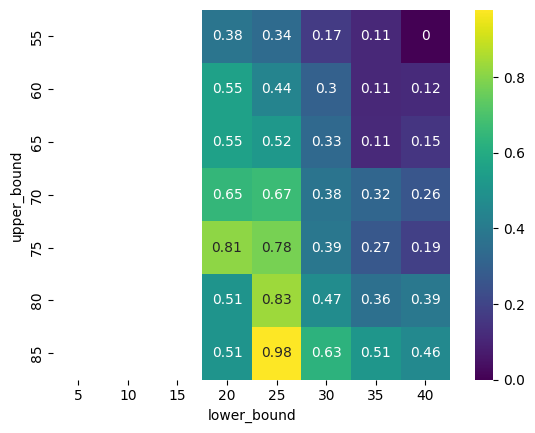

In [138]:
sns.heatmap(hm, annot=True, cmap='viridis')
plt.show()

`lower_bound=25, upper_bound=85` gives the best `Sharpe Ratio=0.98`

In [139]:
# stats.to_frame()

## heatmap for multiple tuning params

In [143]:
stats, heatmap = bt.optimize(
    upper_bound = range(55, 90, 5),
    lower_bound = range(10, 45, 5),
    rsi_window = range(10, 30, 2),
    maximize='Sharpe Ratio',
#     max_tries=100,
    return_heatmap=True
)

/Users/lusong/miniconda3/envs/m1quant/lib/python3.10/site-packages/backtesting/backtesting.py:1488: UserWarning: Searching for best of 490 configurations.
  output = _optimize_grid()
/Users/lusong/miniconda3/envs/m1quant/lib/python3.10/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


In [145]:
plot_heatmaps(heatmap, agg='mean', filename=os.path.join(
    'plots', 'heatmaps.html'))

GridPlot(id='p11950', ...)

## Multi-timeframe strategies
* SMA and RSI

In [247]:
class RsiOscillatorMultitimeframe(Strategy):
    upper_bound = 70
    lower_bound = 30
    rsi_window = 14
    sma_s_window = 3
    sma_l_window = 12

    def init(self):
        self.daily_rsi = self.I(
            talib.RSI,
            self.data.Close,
            self.rsi_window
        )
#         self.weekly_rsi = resample_apply(
#             'W-FRI', talib.RSI, self.data.Close,
#             self.rsi_window
#         )

        self.sma_s = self.I(
            talib.SMA,
            self.data.Close,
            self.sma_s_window
        )
        self.sma_l = self.I(
            talib.SMA,
            self.data.Close,
            self.sma_l_window
        )

    def next(self):
        if all([
            crossover(self.daily_rsi, self.upper_bound),
            self.sma_l[-1] > self.sma_s[-1]
#             crossover(self.sma_l, self.sma_s)
        ]):
            self.position.close()
        elif all([
            crossover(self.lower_bound, self.daily_rsi),
            self.sma_l[-1] < self.sma_s[-1]
#             crossover(self.sma_s, self.sma_l)
        ]):
            self.buy()

In [248]:
TSLA = yf.Ticker("TSLA").history(period="5y")
TSLA.head(3)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-04-09 00:00:00-04:00,20.024668,20.633333,19.280666,19.310667,153747000,0.0,0.0
2018-04-10 00:00:00-04:00,19.931334,20.473333,19.578667,20.313334,164847000,0.0,0.0
2018-04-11 00:00:00-04:00,20.049334,20.598667,19.977333,20.062000,112243500,0.0,0.0


In [249]:
bt = Backtest(
    TSLA,
    RsiOscillatorMultitimeframe,
    cash=10_000
)

stats = bt.optimize(
    upper_bound=range(60, 90, 5),
    lower_bound=range(15, 45, 5),
    rsi_window=range(6, 24, 3),
    sma_l_window=range(10, 24, 3),
    maximize='Sortino Ratio',
)

/Users/lusong/miniconda3/envs/m1quant/lib/python3.10/site-packages/backtesting/backtesting.py:1488: UserWarning: Searching for best of 1080 configurations.
  output = _optimize_grid()
/Users/lusong/miniconda3/envs/m1quant/lib/python3.10/site-packages/backtesting/backtesting.py:1375: UserWarning: For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.
  warnings.warn("For multiprocessing support in `Backtest.optimize()` "


In [252]:
# stats.to_frame()

In [251]:
bt.plot(filename=os.path.join('plots',
                              'RsiOscillatorMultitimeframe.html'))

/Users/lusong/miniconda3/envs/m1quant/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/lusong/miniconda3/envs/m1quant/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


GridPlot(id='p25819', ...)

## Shorting

In [223]:
AAPL = yf.Ticker("AAPL").history(period="5y")
AAPL.head(3)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-04-09 00:00:00-04:00,40.487545,41.252583,40.480396,40.528061,116070800,0.0,0.0
2018-04-10 00:00:00-04:00,41.231139,41.469470,40.880794,41.290722,113634400,0.0,0.0
2018-04-11 00:00:00-04:00,41.047624,41.450403,40.921310,41.097675,89726400,0.0,0.0


In [231]:
class RsiOscillatorLongShort(Strategy):
    upper_bound = 70
    lower_bound = 30
    rsi_window = 14

    def init(self):
        self.daily_rsi = self.I(
            talib.RSI,
            self.data.Close,
            self.rsi_window
        )

    def next(self):
        if crossover(self.daily_rsi, self.upper_bound):
            if self.position.is_long:
#                 print(self.position)
                self.position.close()
                self.sell()
        elif crossover(self.lower_bound, self.daily_rsi):
            if self.position.is_short or not self.position:
#                 print(self.position)
                self.position.close()
                self.buy()

In [232]:
bt = Backtest(
    AAPL,
    RsiOscillatorLongShort,
    cash=10_000
)

stats = bt.run()

In [233]:
bt.plot(filename=os.path.join('plots',
                              'RsiOscillatorLongShort.html'))

/Users/lusong/miniconda3/envs/m1quant/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/lusong/miniconda3/envs/m1quant/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


GridPlot(id='p22394', ...)

In [234]:
# stats.to_frame()

##  Stop loss & Take profit

In [263]:
AAPL = yf.Ticker("AAPL").history(period="5y")
AAPL.head(3)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-04-09 00:00:00-04:00,40.487549,41.252587,40.480399,40.528065,116070800,0.0,0.0
2018-04-10 00:00:00-04:00,41.231136,41.469466,40.880790,41.290718,113634400,0.0,0.0
2018-04-11 00:00:00-04:00,41.047621,41.450399,40.921306,41.097672,89726400,0.0,0.0


In [276]:
class RsiOscillatorPL(Strategy):
    upper_bound = 70
    lower_bound = 30
    rsi_window = 14

    def init(self):
        self.daily_rsi = self.I(
            talib.RSI,
            self.data.Close,
            self.rsi_window
        )

    def next(self):
        current_price = self.data.Close[-1]
        if crossover(self.daily_rsi, self.upper_bound):
            self.position.close()
        elif crossover(self.lower_bound, self.daily_rsi):
            self.buy(
                sl=0.95*current_price,  # stop loss
                tp=1.15*current_price,  # take profit
            )

In [277]:
bt = Backtest(
    AAPL,
    RsiOscillatorPL,
    cash=10_000
)

stats = bt.run()

In [278]:
bt.plot(filename=os.path.join('plots',
                              'RsiOscillatorPL.html'))

/Users/lusong/miniconda3/envs/m1quant/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/lusong/miniconda3/envs/m1quant/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


GridPlot(id='p32523', ...)

In [280]:
# stats.to_frame()

## Size of the position

In [281]:
AAPL = yf.Ticker("AAPL").history(period="5y")
AAPL.head(3)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-04-09 00:00:00-04:00,40.487549,41.252587,40.480399,40.528065,116070800,0.0,0.0
2018-04-10 00:00:00-04:00,41.231136,41.469466,40.880790,41.290718,113634400,0.0,0.0
2018-04-11 00:00:00-04:00,41.047624,41.450403,40.921310,41.097675,89726400,0.0,0.0


### buy in %

In [292]:
class RsiOscillatorSizePct(Strategy):
    upper_bound = 70
    lower_bound = 30
    rsi_window = 14

    def init(self):
        self.daily_rsi = self.I(
            talib.RSI,
            self.data.Close,
            self.rsi_window
        )

    def next(self):
        current_price = self.data.Close[-1]
        if crossover(self.daily_rsi, self.upper_bound):
            self.position.close()
        elif crossover(self.lower_bound, self.daily_rsi):
            self.buy(
                size=0.1, # every time buy 10%
            )

In [293]:
bt = Backtest(
    AAPL,
    RsiOscillatorSizePct,
    cash=10_000
)

stats = bt.run()

In [294]:
bt.plot(filename=os.path.join('plots',
                              'RsiOscillatorSizePct.html'))

/Users/lusong/miniconda3/envs/m1quant/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/lusong/miniconda3/envs/m1quant/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


GridPlot(id='p36967', ...)

In [288]:
# stats.to_frame()

### Buy actual # shares
* dollar cost averaging

In [303]:
class RsiOscillatorSizeShares(Strategy):
    upper_bound = 70
    lower_bound = 30
    rsi_window = 14
    position_size = 1

    def init(self):
        self.daily_rsi = self.I(
            talib.RSI,
            self.data.Close,
            self.rsi_window
        )

    def next(self):
        current_price = self.data.Close[-1]
        if self.daily_rsi[-1] > self.upper_bound:
            self.position.close()
        elif self.lower_bound > self.daily_rsi[-1]:
            self.buy(
                size=self.position_size,  # every time buy 1 share
            )

In [304]:
bt = Backtest(
    AAPL,
    RsiOscillatorSizeShares,
    cash=10_000
)

stats = bt.run()

In [305]:
bt.plot(filename=os.path.join('plots',
                              'RsiOscillatorSizeShares.html'))

/Users/lusong/miniconda3/envs/m1quant/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/lusong/miniconda3/envs/m1quant/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


GridPlot(id='p40300', ...)

In [302]:
# stats.to_frame()

## Extracting Trade Data

In [308]:
stats['_trades']

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
0,1,187,234,34.821047,44.496325,9.675279,0.277857,2019-01-04 00:00:00-05:00,2019-03-14 00:00:00-04:00,68 days 23:00:00
1,1,181,234,35.729339,44.496325,8.766986,0.245372,2018-12-26 00:00:00-05:00,2019-03-14 00:00:00-04:00,77 days 23:00:00
2,1,180,234,35.693204,44.496325,8.803122,0.246633,2018-12-24 00:00:00-05:00,2019-03-14 00:00:00-04:00,79 days 23:00:00
3,1,179,234,37.791663,44.496325,6.704662,0.177411,2018-12-21 00:00:00-05:00,2019-03-14 00:00:00-04:00,82 days 23:00:00
4,1,163,234,42.578866,44.496325,1.917459,0.045033,2018-11-28 00:00:00-05:00,2019-03-14 00:00:00-04:00,105 days 23:00:00
5,1,162,234,41.321231,44.496325,3.175094,0.076839,2018-11-27 00:00:00-05:00,2019-03-14 00:00:00-04:00,106 days 23:00:00
6,1,161,234,41.978969,44.496325,2.517356,0.059967,2018-11-26 00:00:00-05:00,2019-03-14 00:00:00-04:00,107 days 23:00:00
7,1,160,234,42.147600,44.496325,2.348725,0.055726,2018-11-23 00:00:00-05:00,2019-03-14 00:00:00-04:00,110 days 23:00:00
8,1,159,234,43.301643,44.496325,1.194682,0.027590,2018-11-21 00:00:00-05:00,2019-03-14 00:00:00-04:00,112 days 23:00:00
9,1,290,388,42.612823,58.798180,16.185357,0.379824,2019-06-04 00:00:00-04:00,2019-10-22 00:00:00-04:00,140 days 00:00:00


## Bar Since Function

In [320]:
class RsiOscillatorBarssince(Strategy):
    upper_bound = 70
    lower_bound = 30
    rsi_window = 14
    position_size = 0.1

    def init(self):
        self.daily_rsi = self.I(
            talib.RSI,
            self.data.Close,
            self.rsi_window
        )

    def next(self):
        current_price = self.data.Close[-1]
        if (self.daily_rsi[-1] > self.upper_bound) and barssince(
            self.daily_rsi < self.upper_bound
        )==3:
            self.position.close()
        elif (self.lower_bound > self.daily_rsi[-1]):
            self.buy(
                size=self.position_size,  # every time buy 1 share
            )

In [321]:
bt = Backtest(
    AAPL,
    RsiOscillatorBarssince,
    cash=10_000
)

stats = bt.run()

In [322]:
bt.plot(filename=os.path.join('plots',
                              'RsiOscillatorSizeShares.html'))

/Users/lusong/miniconda3/envs/m1quant/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/lusong/miniconda3/envs/m1quant/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


GridPlot(id='p44744', ...)

In [325]:
# stats.to_frame()

# Backtest Dollar Cost Average Strategy

In [356]:
AAPL = yf.Ticker("AAPL").history(period="5y")
AAPL.tail(3)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-04-04 00:00:00-04:00,166.600006,166.839996,165.110001,165.630005,46278300,0.0,0.0
2023-04-05 00:00:00-04:00,164.740005,165.050003,161.800003,163.759995,51511700,0.0,0.0
2023-04-06 00:00:00-04:00,162.429993,164.960007,162.000000,164.660004,45390100,0.0,0.0


In [365]:
class DCA(Strategy):
    amt_to_invest = 10000

    def init(self):
        self.day_of_week = self.I(
            lambda x: x, self.data.Close.s.index.dayofweek,
            plot=True
        )

    def next(self):
        if self.day_of_week[-1] == 1:  # every tuesday
            self.buy(size=math.floor(
                self.amt_to_invest/self.data.Close[-1]))

In [366]:
bt = Backtest(
    AAPL,
    DCA,
    cash=1_000_000
)
stats = bt.run()

In [379]:
# stats.to_frame()

In [369]:
bt.plot(filename=os.path.join('plots',
                              'DCA.html'))

/Users/lusong/miniconda3/envs/m1quant/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/lusong/miniconda3/envs/m1quant/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


GridPlot(id='p49188', ...)

In [371]:
trades = stats['_trades']

In [374]:
price_paid = trades['Size']*trades['EntryPrice']
total_invested = price_paid.sum()

In [375]:
total_invested

990800.0922727807

In [377]:
current_shares = trades['Size'].sum()
current_equity = current_shares*AAPL.Close.iloc[-1]

In [378]:
current_equity

3254998.952392578

# Custom Indicators In Backtesting.py

In [387]:
AAPL = yf.Ticker("AAPL").history(period="5y")
AAPL.tail(3)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-04-04 00:00:00-04:00,166.600006,166.839996,165.110001,165.630005,46278300,0.0,0.0
2023-04-05 00:00:00-04:00,164.740005,165.050003,161.800003,163.759995,51511700,0.0,0.0
2023-04-06 00:00:00-04:00,162.429993,164.960007,162.000000,164.660004,45390100,0.0,0.0


## Random Singnal

In [405]:
# random signal
# if we have a fancy machine learning model generated signal
# we can incorporate here
AAPL['Signal'] = np.random.randint(-1, 2, len(AAPL))

In [406]:
class SignalStrategy(Strategy):
    
    def init(self):
        pass

    def next(self):
        current_signal = self.data.Signal[-1]
        if current_signal==1:
            if not self.position.is_long:
                self.buy()
        elif current_signal== -1:
            if self.position:
                self.position.close()

In [407]:
bt = Backtest(
    AAPL,
    SignalStrategy,
    cash=10_000
)
stats = bt.run()

In [408]:
# stats.to_frame()

In [409]:
bt.plot(filename=os.path.join('plots',
                              'SignalStrategy.html'))

/Users/lusong/miniconda3/envs/m1quant/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/lusong/miniconda3/envs/m1quant/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


GridPlot(id='p51332', ...)

## Signal built with Bollinger Bands
* not a good strategy here
* `indicator` 在 `self.I` 里面运行时，`self.data.Close.s` 是必须的，转化成series
* `indicator` 在 `self.data.Close` 上单独运行不需要`.s`

In [560]:
def indicator_bollinger(data):
    # Data - OHLCV

    bbands = pdta.bbands(
        close=data.Close.s,
        std=1
    )
    
    return bbands.T.to_numpy()
    
#     bbands = talib.BBANDS(
#         data.Close,
#         timeperiod=5,
#         nbdevup=1,
#         nbdevdn=1,
#         matype=0
#     )
#     return bbands

In [561]:
class BBStrategy(Strategy):
    def init(self):
        self.bbands = self.I(
            indicator_bollinger,
            self.data
        )

    def next(self):
#         upper_band = self.bbands[0]
#         lower_band = self.bbands[2]
        
        upper_band = self.bbands[2]
        lower_band = self.bbands[0]

        if self.position:
            if self.data.Close[-1] > upper_band[-1]:
                self.position.close()
        else:
            if self.data.Close[-1] < lower_band[-1]:
                self.buy()

In [562]:
bt = Backtest(
    AAPL,
    BBStrategy,
    cash=10_000
)
stats = bt.run()

In [564]:
# stats.to_frame()

In [565]:
bt.plot(filename=os.path.join('plots',
                              'BBStrategy.html'))

/Users/lusong/miniconda3/envs/m1quant/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/lusong/miniconda3/envs/m1quant/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


GridPlot(id='p61117', ...)

## Momentum strategy using pandas
* 这个strategy不错，跟随趋势做

In [566]:
def indicator_momentum(data):
    # Data - OHLCV
    return data.Close.s.pct_change(
        periods = 7 # weekly change
    )*100

In [555]:
# indicator_momentum(AAPL)

In [567]:
class MomentumStrategy(Strategy):
    def init(self):
        self.pct_change = self.I(
            indicator_momentum,
            self.data
        )
        print(self.pct_change)

    def next(self):
        change = self.pct_change[-1]
        if self.position:
            if change < -5:
                self.position.close()
        else:
            if change > 5:
                self.buy()

In [568]:
bt = Backtest(
    AAPL,
    MomentumStrategy,
    cash=10_000
)
stats = bt.run()

[       nan        nan        nan ... 3.35725734 3.46221618 4.4465652 ]


In [570]:
# stats.to_frame()

In [571]:
bt.plot(filename=os.path.join('plots',
                              'MomentumStrategy.html'))

/Users/lusong/miniconda3/envs/m1quant/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
/Users/lusong/miniconda3/envs/m1quant/lib/python3.10/site-packages/backtesting/_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


GridPlot(id='p62304', ...)